In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import warnings
import pickle

warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv("car data.csv")


In [4]:
# Display dataset information
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
df.info()
df.drop_duplicates(inplace=True)

Number of rows: 301
Number of columns: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
# Add Age column
df['Age'] = 2024 - df['Year']

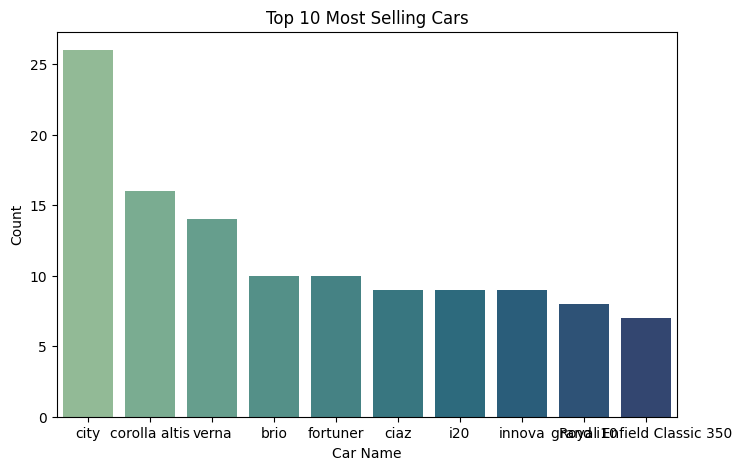

In [6]:
# Visualize top 10 most selling cars
top10 = df['Car_Name'].value_counts()[:10]
plt.figure(figsize=(8, 5))
sns.countplot(x='Car_Name', data=df, order=top10.index, palette='crest')
plt.title('Top 10 Most Selling Cars')
plt.xlabel('Car Name')
plt.ylabel('Count')
plt.show()

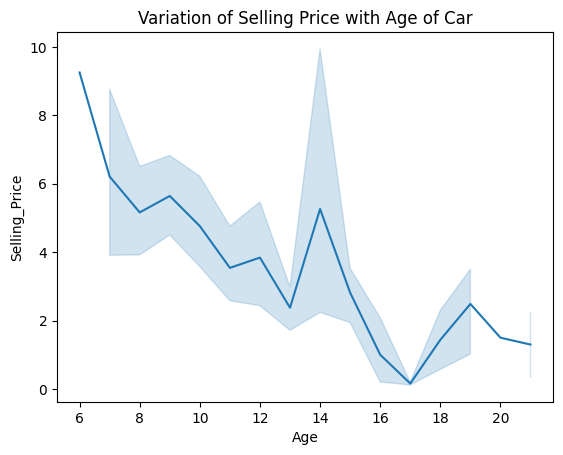

In [7]:
# Selling Price vs. Age of Car
sns.lineplot(x='Age', y='Selling_Price', data=df).set_title('Variation of Selling Price with Age of Car')
plt.show()

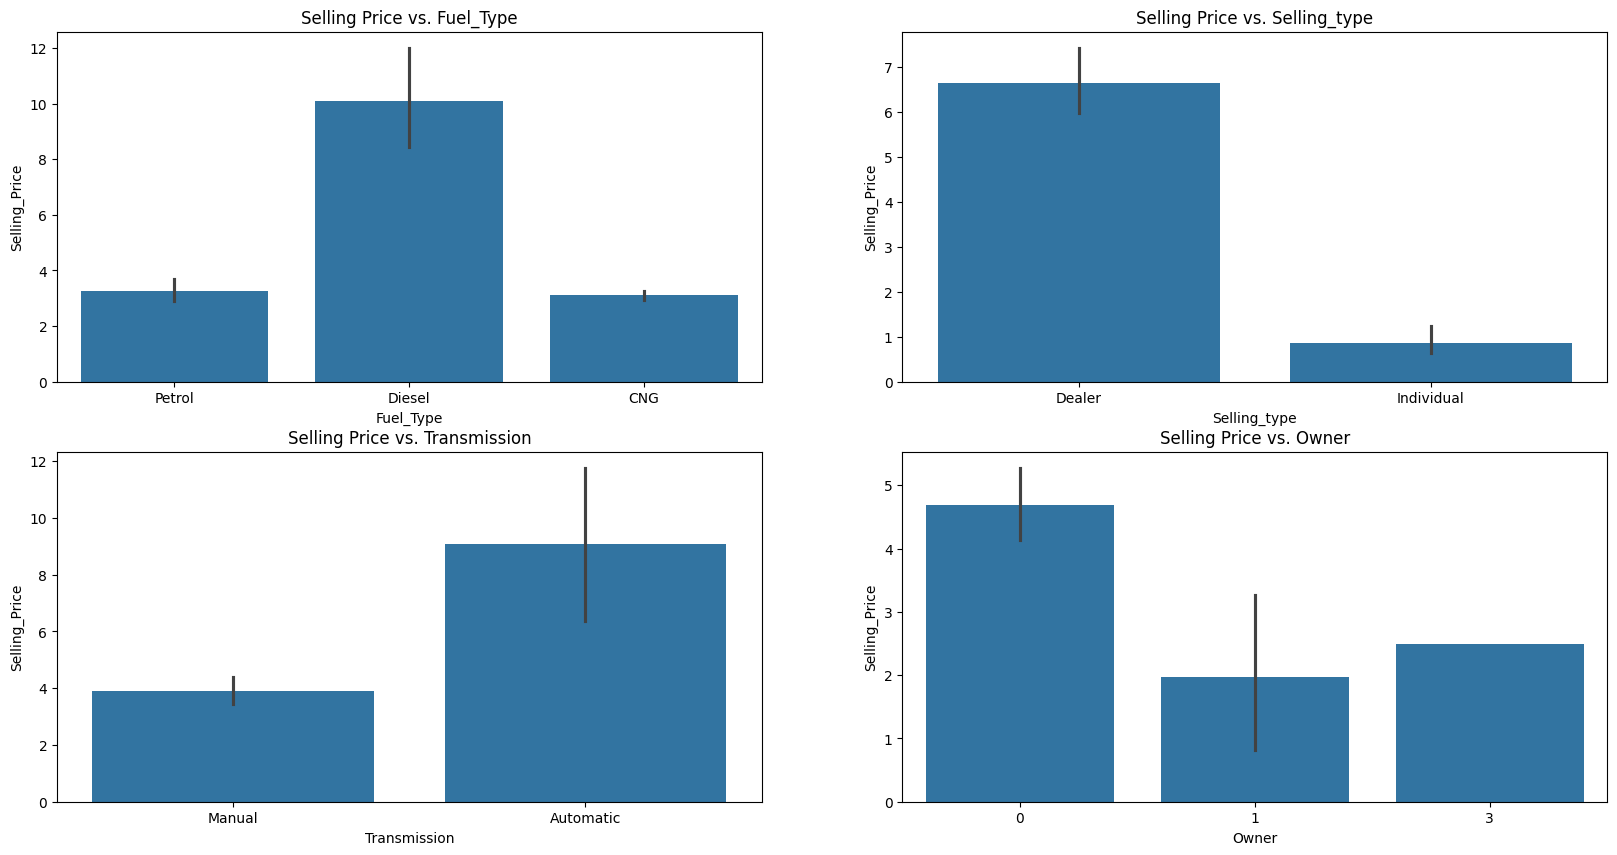

In [8]:
# Bar plots for categorical variables vs. Selling Price
plt.figure(figsize=(20, 10))
for i, col in enumerate(['Fuel_Type', 'Selling_type', 'Transmission', 'Owner']):
    plt.subplot(2, 2, i+1)
    sns.barplot(data=df, x=col, y='Selling_Price')
    plt.title(f'Selling Price vs. {col}')
plt.show()

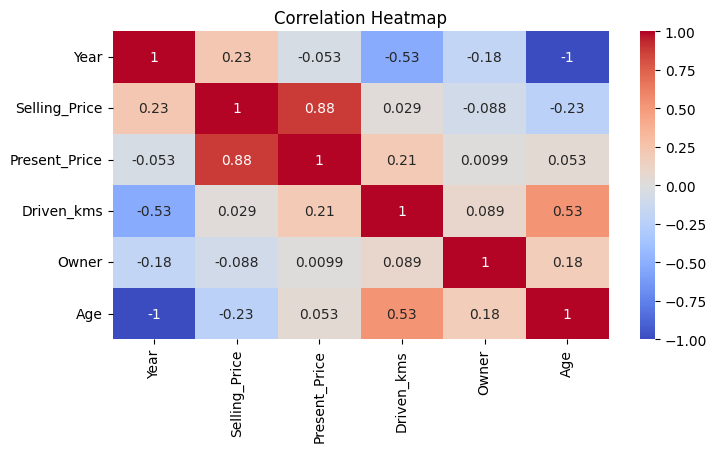

In [9]:
# Correlation heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[['Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Owner', 'Age']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [10]:
# Handle outliers using IQR method
q1, q3 = df['Selling_Price'].quantile([0.25, 0.75])
df['Selling_Price'] = np.where(df['Selling_Price'] > (q3 + 1.5 * (q3 - q1)), q3, df['Selling_Price'])

In [11]:
# Encode categorical variables
cat_columns = ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']
label_encoders = {col: LabelEncoder().fit(df[col]) for col in cat_columns}
df_encoded = df[cat_columns].apply(lambda col: label_encoders[col.name].transform(col))
df = df.drop(columns=cat_columns).join(df_encoded)

In [12]:
# Prepare data for modeling
X = df.drop(columns=['Selling_Price'])
y = df['Selling_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Standardize features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [14]:
# Model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        "Mean Squared Error": mean_squared_error(y_test, y_pred),
        "Mean Absolute Error": mean_absolute_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred),
    }
    return metrics

In [17]:
# Model evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=500),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200),
    "SVR": SVR(),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
}

In [18]:
for name, model in models.items():
    metrics = evaluate_model(model, X_train_s, y_train, X_test_s, y_test)
    print(f"{name} Metrics: {metrics}")

Linear Regression Metrics: {'Mean Squared Error': np.float64(4.014479376344644), 'Mean Absolute Error': np.float64(1.2726340707392587), 'R2 Score': 0.6702080182741159}
Decision Tree Metrics: {'Mean Squared Error': np.float64(0.7532766666666666), 'Mean Absolute Error': np.float64(0.5556666666666668), 'R2 Score': 0.9381178525535061}
Random Forest Metrics: {'Mean Squared Error': np.float64(1.156711736346662), 'Mean Absolute Error': np.float64(0.679958666666664), 'R2 Score': 0.9049754102454245}
Gradient Boosting Metrics: {'Mean Squared Error': np.float64(1.5255268377035962), 'Mean Absolute Error': np.float64(0.7495224144129268), 'R2 Score': 0.8746770199027925}
SVR Metrics: {'Mean Squared Error': np.float64(2.4087972142876017), 'Mean Absolute Error': np.float64(0.9432594346756361), 'R2 Score': 0.8021158082024986}
MLP Regressor Metrics: {'Mean Squared Error': np.float64(1.5691744276671356), 'Mean Absolute Error': np.float64(0.8128875080428183), 'R2 Score': 0.8710913431955075}


In [20]:
# Save the best model (MLP Regressor)
with open("mlp_regressor.pkl", "wb") as f:
    pickle.dump(models["MLP Regressor"], f)